# <center>Neural Spline Flows [1]</center>

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import matplotlib.pyplot as plt
import numpy as np

import sklearn.datasets as datasets

from NF_base import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
class shifting(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(nh,nh))
        self.layers.append(nn.Linear(nh,d_out))

    def forward(self, x):
        for layer in self.layers:
            x = F.leaky_relu(layer(x),0.2)
        return x

class scaling(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(nh,nh))
        self.layers.append(nn.Linear(nh,d_out))

    def forward(self, x):
        for layer in self.layers:
            x = torch.tanh(layer(x))
        return x
    
    
class mlp_relu(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(nh,nh))
        self.layers.append(nn.Linear(nh,d_out))

    def forward(self, x):
        for layer in self.layers:
            x = torch.relu(layer(x))
        return x

**Neural spline flows:** Replace affine/additive coupling layers by monotonic rational quadratic transforms

**Monotonic rational-quadratic transforms:** 
- Learn $K+1$ knots $(x^{(k)},y^{(k)})_{k=0}^K$ with $(x^{(0)},y^{(0)})=(-B,-B)$ and $(x^{(K)},y^{(K)})=(B,B)$.
- Learn $K-1$ derivative values for the spline at each knot $(\delta_k)_{k=1}^K$. Set $\deta_0=\delta_1=1$.
- Set $s_k = \frac{y^{(k+1)}-y^{(k)}}{x^{(k+1)}-x^{(k)}}$, $\xi_k(x) = \frac{x-x^{(k)}}{x^{(k+1)}-x^{(k)}}$
- The value of the spline at a point $x\in[x^{(k)},x^{(k+1)}]$,
\begin{equation*}
    \frac{\alpha_k(\xi)}{\beta_k(\xi)} = y^{(k)}+\frac{(y^{(k+1)}-y^{(k)})(s_k\xi^2+\delta_k\xi(1-\xi))}{s_k+(\delta_{k+1}+\delta_k-2s_k)\xi(1-\xi)^2}
\end{equation*}

This expression can be differentiated and inverted analytically.



In [4]:
!pip install nflows

In [5]:
from nflows.transforms.splines.rational_quadratic import rational_quadratic_spline, \
                                                         unconstrained_rational_quadratic_spline

In [6]:
class NeuralSplineFlow(BaseNormalizingFlow):
    """
        Inspiraton: https://github.com/noegroup/stochastic_normalizing_flows/blob/109ab7feb4d539cad1de7cf9d64f76e4234f358e/snf_code/snf_code/flowtools.py
    """
    def __init__(self, dim, K, width_net, height_net, deriv_net, tail=1.5):
        super().__init__()
        self.K = K
        self.width_net = width_net
        self.height_net = height_net
        self.deriv_net = deriv_net
        self.tail_bound = tail
        
        self.d = dim//2
        
    def forward(self, x):
        x0, x1 = x[:,:self.d], x[:,self.d:]
        
        w = self.width_net(x0).view(x0.size(0),-1,self.K)
        h = self.height_net(x0).view(x0.size(0),-1,self.K)
        deriv = self.deriv_net(x0).view(x0.size(0),-1,self.K-1)
        
        z0 = x0
        z1, log_det = unconstrained_rational_quadratic_spline(x1,w,h,deriv,tail_bound=self.tail_bound)

        z = torch.cat([z0,z1],dim=1)
        return z, log_det.sum(dim=-1)
    
    def backward(self, z):
        z0, z1 = z[:,:self.d], z[:,self.d:]
        
        w = self.width_net(z0).view(z0.size(0),-1,self.K)
        h = self.height_net(z0).view(z0.size(0),-1,self.K)
        deriv = self.deriv_net(z0).view(z0.size(0),-1,self.K-1)
        
        x0 = z0
        x1, log_det = unconstrained_rational_quadratic_spline(z1,w,h,deriv,inverse=True,tail_bound=self.tail_bound)

        x = torch.cat([x0,x1],dim=1)
        return x, log_det.sum(dim=-1)

## Moons

In [7]:
def train_moons(model, n_epochs=10001):
    d = 2
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    train_loss = []

    for i in range(n_epochs):
        x, y = datasets.make_moons(128, noise=.1)
        x = torch.tensor(x, dtype=torch.float32).to(device)

        model.train()

        z, log_det = model(x)
        l = loss(z[-1],log_det)

        l.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss.append(l.item())
        
        if i%100==0:
            print(i,train_loss[-1])

        if (i + 1) % 500 == 0:
            model.eval()

            xline = torch.linspace(-1.5, 2.5)
            yline = torch.linspace(-.75, 1.25)
            xgrid, ygrid = torch.meshgrid(xline, yline)
            xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

            with torch.no_grad():
                xy, log_s = model(xyinput.to(device))
                zz = (log_likelihood(xy[-1],log_s)).exp().cpu()
                zgrid = zz.reshape(100,100)


                z = base_distr.sample((100,))
                xs, _ = model.backward(z)
                x = xs[-1].detach()
                x = x.cpu().numpy()
                z = z.cpu().numpy()

            plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
            plt.colorbar()
            plt.scatter(x[:,0],x[:,1],c="red")
            plt.scatter(z[:,0],z[:,1],c="green")
            plt.xlim(-1.5,2.5)
            plt.ylim(-0.75,1.25)
            plt.title('iteration {}'.format(i + 1))
            plt.show()
            
    return train_loss

In [8]:
def loss(h,log_det,d=2):
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    prior = base_distr.log_prob(h).mean()
    return -(prior+log_det.mean())

def log_likelihood(h,log_det,d=2):
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    prior = base_distr.log_prob(h)
    return prior+log_det

In [9]:
d = 2
bins = 32

width_nets = [mlp_relu(d//2,64,bins,3) for k in range(5)]
height_nets = [mlp_relu(d//2,64,bins,3) for k in range(5)]
deriv_nets = [mlp_relu(d//2,64,bins-1,3) for k in range(5)]

flows = []
for i in range(5):
    flows.append(ActNorm(dim=d))
    flows.append(LUInvertible(dim=d))
    flows.append(NeuralSplineFlow(d,bins,width_nets[i],height_nets[i],deriv_nets[i]))

model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  220065


0 1.9518389701843262
100 1.886107087135315
200 1.8244667053222656
300 1.8076930046081543
400 1.78788161277771


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)


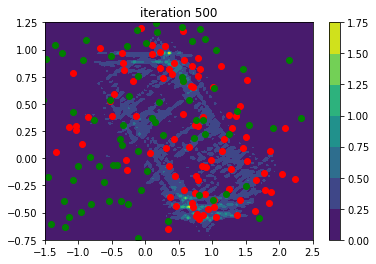

500 1.579827070236206
600 1.7544958591461182
700 1.674332857131958
800 1.6770285367965698
900 1.6258773803710938


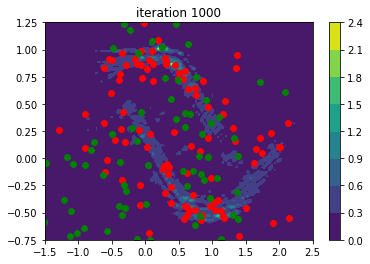

1000 1.6248397827148438
1100 1.5389484167099
1200 1.5376174449920654
1300 1.432945966720581
1400 1.6281038522720337


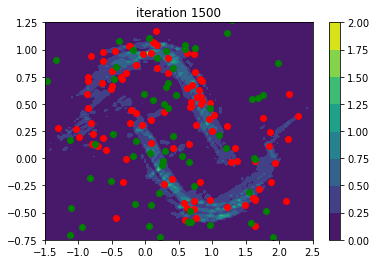

1500 1.4269309043884277
1600 1.4011836051940918
1700 1.4778857231140137
1800 1.4783589839935303
1900 1.4341387748718262


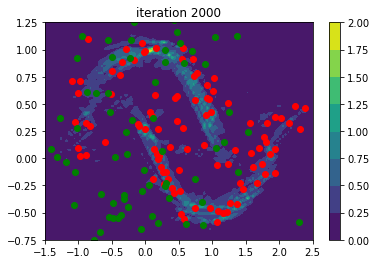

2000 1.33150053024292
2100 1.5172410011291504
2200 1.324845552444458
2300 1.524596095085144
2400 1.2341413497924805


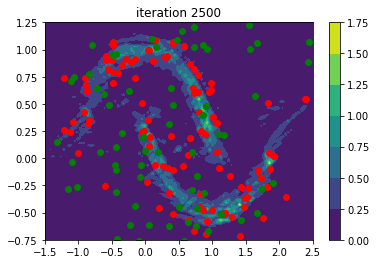

2500 1.2473868131637573
2600 1.325860619544983
2700 1.2183072566986084
2800 1.3197458982467651
2900 1.1706275939941406


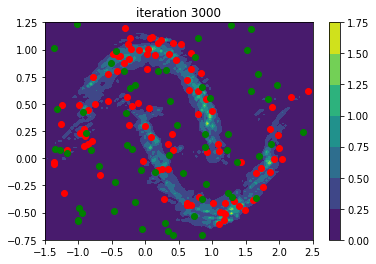

3000 1.495719075202942
3100 1.317274808883667
3200 1.2541308403015137
3300 1.2313377857208252
3400 1.3685946464538574


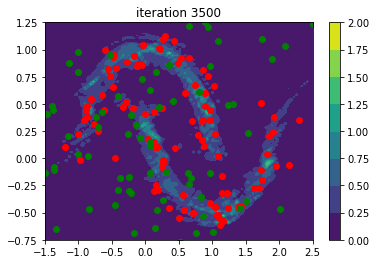

3500 1.2318265438079834
3600 1.1814559698104858
3700 1.3817405700683594
3800 1.2136236429214478
3900 1.2867310047149658


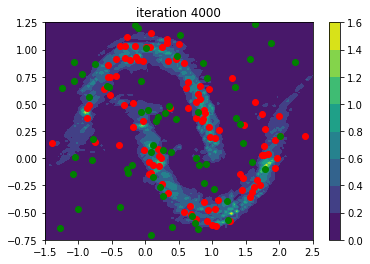

4000 1.1437959671020508
4100 1.3467613458633423
4200 1.235973834991455
4300 1.2981610298156738
4400 1.0511984825134277


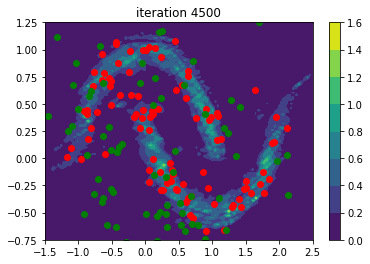

4500 1.0523223876953125
4600 1.2020344734191895
4700 1.3025965690612793
4800 1.1778079271316528
4900 1.1875896453857422


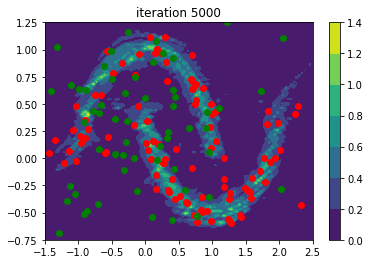

5000 1.204343318939209
5100 1.1628391742706299
5200 1.1758636236190796
5300 1.1518173217773438
5400 1.364755392074585


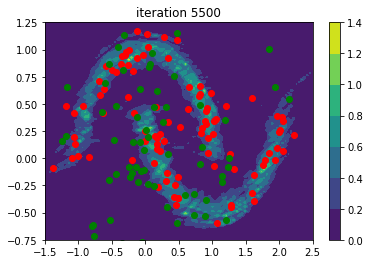

5500 1.1455192565917969
5600 1.157178521156311
5700 1.2269768714904785
5800 1.1635773181915283
5900 1.0841397047042847


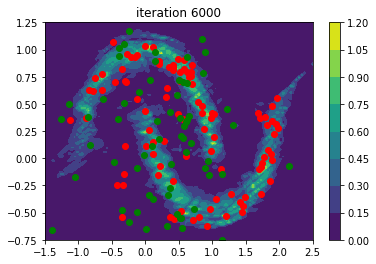

6000 1.0088317394256592
6100 1.2187013626098633
6200 1.2506325244903564
6300 1.0629615783691406
6400 1.1844638586044312


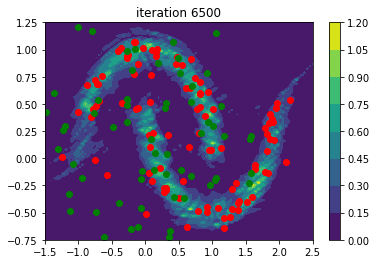

6500 1.2097787857055664
6600 1.215425729751587
6700 1.0940349102020264
6800 1.1859960556030273
6900 1.2520877122879028


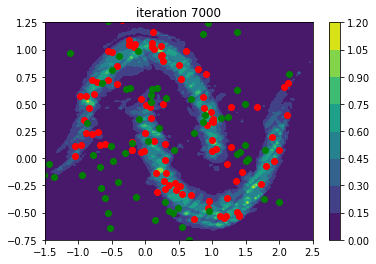

7000 1.1640403270721436
7100 1.142195701599121
7200 1.1568784713745117
7300 1.0993525981903076
7400 1.126320481300354


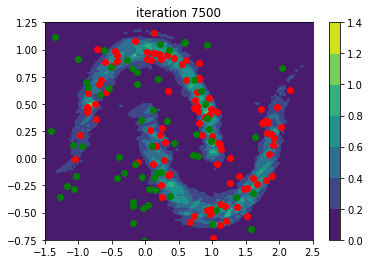

7500 1.1010628938674927
7600 1.1837526559829712
7700 1.2047260999679565
7800 1.1501357555389404
7900 1.1864439249038696


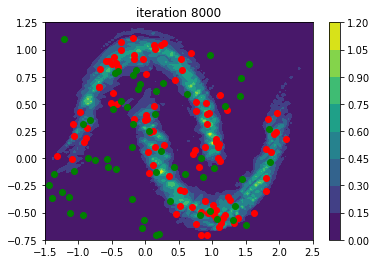

8000 1.1230096817016602
8100 1.1317219734191895
8200 1.181815505027771
8300 1.064321517944336
8400 1.1980805397033691


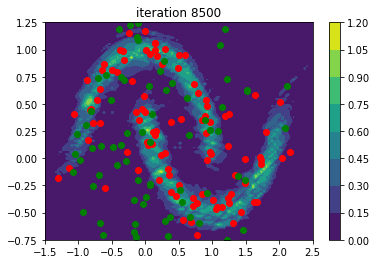

8500 1.0679285526275635
8600 1.0546867847442627
8700 1.2347517013549805
8800 1.1051286458969116
8900 1.0828951597213745


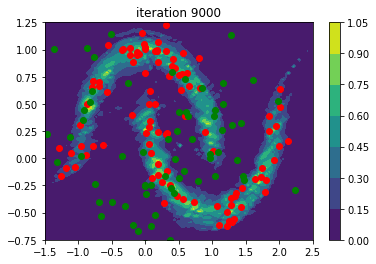

9000 1.1475238800048828
9100 1.1213291883468628
9200 1.2302014827728271
9300 1.1712086200714111
9400 1.194295883178711


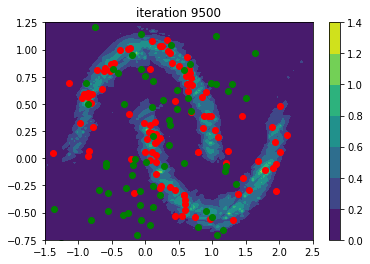

9500 1.1437335014343262
9600 1.102513074874878
9700 1.0962951183319092
9800 1.0905640125274658
9900 1.1904709339141846


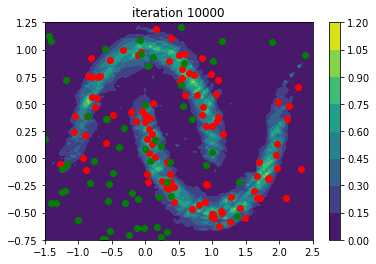

10000 1.1476703882217407


In [10]:
train_loss = train_moons(model)

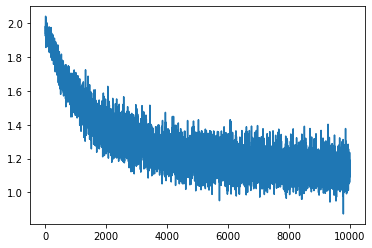

In [11]:
plt.plot(train_loss)
plt.show()

## References

<a id="reference1"></a>

[1] Durkan, C., Besakov, A., Murray, I. & Papamakarios, G. Neural Spline Flows. arXiv preprint arXiv:1906.04032. (2019). [link](https://arxiv.org/pdf/1906.04032)